In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3426, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 3426 (delta 52), reused 100 (delta 44), pack-reused 3302
Receiving objects: 100% (3426/3426), 643.49 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
Updating files: 100% (222/222), done.


In [ ]:
device ="cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [ ]:
import os 
import zipfile
from pathlib import Path

import requests 

def download_data(source :str,
                  destination :str,
                  remove_source:bool=True ) -> Path:

    data_path= Path("data/")
    image_path= data_path / destination

    if image_path.is_dir():
      print(f"[INFO] {image_path} directory exists ,skipping download.")

    else :
      print(f"[INFO] Did not find {image_path} directory ,creating one ...")
      image_path.mkdir(parents=True ,exist_ok=True)

      target_file=Path(source).name
      with open(data_path /target_file , "wb") as f :
        request =requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)


      with zipfile.ZipFile(data_path / target_file ,"r") as zip_ref :
        print(f"[INFO] Unzipping {target_file} data ...")
        zip_ref.extractall(image_path)

      if remove_source:
        os.remove(data_path /target_file)
    
    return image_path 


In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory ,creating one ...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data ...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir

PosixPath('data/pizza_steak_sushi_20_percent/train')

In [ ]:
effnetb2_weights =torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms=effnetb2_weights.transforms()

effnetb2=torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad=False
  

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
effnetb2.classifier =nn.Sequential(
    nn.Dropout(p=0.3 ,inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

In [ ]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [ ]:
from torchinfo import summary 
summary(effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

NUM_WORKERS =os.cpu_count()

def create_dataloaders(
    train_dir :str,
    test_dir :str,
    transform:transforms.Compose,
    batch_size:int,
    num_workers:int =NUM_WORKERS ):
  train_data=datasets.ImageFolder(train_dir,transform=transform)
  test_data=datasets.ImageFolder(test_dir,transform=transform)

  class_names=train_data.classes

  train_dataloader =DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True
  )
  test_dataloader=DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle =True,
      num_workers=num_workers,
      pin_memory=True
  )
  return train_dataloader ,test_dataloader,class_names

In [ ]:
train_dataloader_effnetb2,test_dataloader_effnetb2,class_names =create_dataloaders(train_dir,
                                                                                   test_dir,
                                                                                   effnetb2_transforms,
                                                                                   32
                                                                                   )

In [ ]:
def set_seeds(seed:int =42):
  torch.manual_seed(seed)

  torch.cuda.manual_seed(seed)

In [ ]:
from torch.nn.modules import loss
import torch 
from tqdm.auto import tqdm
from typing import Dict,List,Tuple 
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device) -> Tuple[float,float] :
      model.train()

      train_loss,train_acc =0,0

      for batch ,(x,y) in enumerate(dataloader):
        x,y=x.to(device),y.to(device)

        y_pred=model(x)

        loss=loss_fn(y_pred,y)
        train_loss +=loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc+=(y_pred_class ==y ).sum().item()/len(y_pred)

      train_loss=train_loss /len(dataloader)
      train_acc =train_acc / len(dataloader)

      return train_loss,train_acc

def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device) ->Tuple[float,float]:

    model.eval()

    test_loss,test_acc=0,0

    with torch.inference_mode():
      for batch,(x,y) in enumerate(dataloader):
        x,y =x.to(device),y.to(device)

        test_pred_logits=model(x)

        loss=loss_fn(test_pred_logits, y)
        test_loss +=loss.item()

        test_pred_labels=test_pred_logits.argmax(dim=1)
        test_acc +=((test_pred_labels == y).sum().item()/ len(test_pred_labels))
    test_loss=test_loss/ len(dataloader)
    test_acc=test_acc / len(dataloader)

    return test_loss ,test_acc

def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn :torch.nn.Module,
          epochs:int,
          device:torch.device) -> Dict[str ,List] :

    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }


    for epoch in tqdm(range(epochs)):
      train_loss,train_acc =train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
      test_loss,test_acc =test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
      print(
          f"Epoch :{epoch+1} |"
          f"train_loss:{train_loss:.4f} |"
          f"train_acc:{train_acc:.4f} |"
          f"test_loss:{test_loss:.4f} |"
          f"test_acc:{test_acc:.4f} |"
      )

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

    return results

In [ ]:
optimizer=torch.optim.Adam(params=effnetb2.parameters(),
                           lr=1e-3)

loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results=train(model=effnetb2,
                       train_dataloader=train_dataloader_effnetb2,
                       test_dataloader=test_dataloader_effnetb2,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :1 |train_loss:0.9848 |train_acc:0.5667 |test_loss:0.7365 |test_acc:0.9409 |
Epoch :2 |train_loss:0.7366 |train_acc:0.8292 |test_loss:0.5523 |test_acc:0.9313 |
Epoch :3 |train_loss:0.5337 |train_acc:0.9062 |test_loss:0.4985 |test_acc:0.9534 |
Epoch :4 |train_loss:0.4666 |train_acc:0.8958 |test_loss:0.4128 |test_acc:0.9534 |
Epoch :5 |train_loss:0.4237 |train_acc:0.8917 |test_loss:0.3766 |test_acc:0.9659 |
Epoch :6 |train_loss:0.3932 |train_acc:0.9250 |test_loss:0.3300 |test_acc:0.9625 |
Epoch :7 |train_loss:0.3660 |train_acc:0.8833 |test_loss:0.3277 |test_acc:0.9386 |
Epoch :8 |train_loss:0.3810 |train_acc:0.8708 |test_loss:0.2994 |test_acc:0.9625 |
Epoch :9 |train_loss:0.3090 |train_acc:0.9187 |test_loss:0.2851 |test_acc:0.9659 |
Epoch :10 |train_loss:0.2772 |train_acc:0.9542 |test_loss:0.2708 |test_acc:0.9563 |


In [ ]:
def plot_loss_curves(results: Dict [str ,List[float]]) :
  # Get the loss values of the results dictionary (training and test)
  loss =results['train_loss']
  test_loss=results['test_loss']

  # Get the accuracy values of the results dictionary (trainig and test)
  accuracy =results["train_acc"]
  test_accuracy=results["test_acc"]


  # Figure out how many epochs there were
  epochs=range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot Loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,test_loss,label='test_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label='train_accuracy')
  plt.plot(epochs,test_accuracy,label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()


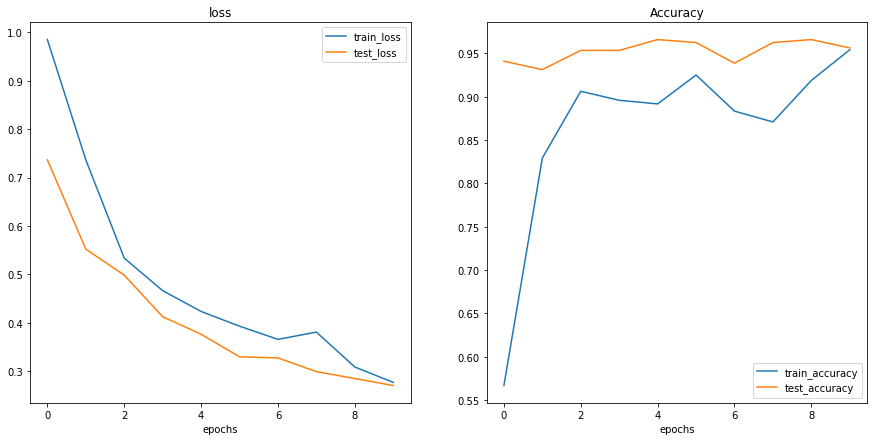

In [ ]:
# from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
import torch
from pathlib import Path

def save_model(model:torch.nn.Module,
               target_dir:str,
               model_name:str) :
    #create target directory
    target_dir_path=Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)
    
    #create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"),"model_name should end with '.pt' or '.pth'"
    model_save_path =target_dir_path / model_name

    #save the model state_dict()
    print(f"[INFO] Saving model to : {model_save_path }")
    torch.save(obj=model.state_dict(),
               f=model_save_path)

In [ ]:
# from going_modular.going_modular import utils

# Save the model
save_model(model=effnetb2,
          target_dir="models",
          model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to : models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [ ]:
# count number of parameters in EffnetB2
effnetb2_total_params=sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# create a dictionary with EffNetB2 statistics
effnetb2_state={"test_loss":effnetb2_results["test_loss"][-1] ,
                "test_acc":effnetb2_results["test_acc"][-1] ,
                "number_of_parameters": effnetb2_total_params ,
                "model_size (MB)":pretrained_effnetb2_model_size ,}
effnetb2_state

{'test_loss': 0.2707937240600586,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes :int =3,
                     seed :int =42) :
    """Creates a ViT-B/16 feature extractor model and transforms.
    
    Args :
      num_classes(int,optional) :number of target classes.Default to 3.
      seed(int,optional):random seed value for outputlayer .Default  to 42.

    Returns:
      model(torch.nn.Module) :ViT-B/16 feature extractor model.
      transform(torchvision.transforms):ViT-B/16 image transforms.

    """
    #create ViT_B_16 pretrained weights,transforms and model
    weights=torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms=weights.transforms()
    model= torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
      param.requires_grad= False
    
    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads=nn.Sequential(nn.Linear(in_features=768 , # Kepp this the same as original model
                                        out_features=num_classes )) # Update to reflect target number of classes

    return model,transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
from torchinfo import summary
# Print ViT features model summary 
summary(
    vit,
    (1,3,224,224),
    col_names=["input_size","output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Setup ViT DataLoaders

train_dataloader_vit ,test_dataloader_vit,class_names =create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=vit_transforms,batch_size=32)

In [ ]:
# Setup optimizer 
optimizer=torch.optim.Adam(params=vit.parameters(),
                           lr=1e-3)
#setup loss function 
loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()
vit_results=train(model=vit,
                  train_dataloader=train_dataloader_vit,
                  test_dataloader=test_dataloader_vit,
                  epochs=10,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :1 |train_loss:0.7023 |train_acc:0.7500 |test_loss:0.2613 |test_acc:0.9347 |
Epoch :2 |train_loss:0.2196 |train_acc:0.9458 |test_loss:0.1490 |test_acc:0.9688 |
Epoch :3 |train_loss:0.1533 |train_acc:0.9583 |test_loss:0.1125 |test_acc:0.9750 |
Epoch :4 |train_loss:0.1306 |train_acc:0.9604 |test_loss:0.0959 |test_acc:0.9722 |
Epoch :5 |train_loss:0.1081 |train_acc:0.9688 |test_loss:0.0819 |test_acc:0.9784 |
Epoch :6 |train_loss:0.0986 |train_acc:0.9771 |test_loss:0.0770 |test_acc:0.9812 |
Epoch :7 |train_loss:0.0914 |train_acc:0.9812 |test_loss:0.0725 |test_acc:0.9847 |
Epoch :8 |train_loss:0.0732 |train_acc:0.9854 |test_loss:0.0642 |test_acc:0.9875 |
Epoch :9 |train_loss:0.0649 |train_acc:0.9854 |test_loss:0.0601 |test_acc:0.9812 |
Epoch :10 |train_loss:0.0560 |train_acc:0.9875 |test_loss:0.0608 |test_acc:0.9750 |


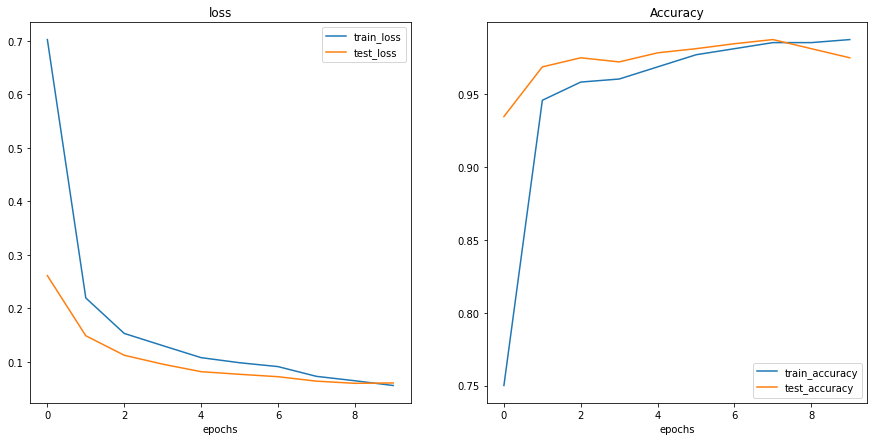

In [ ]:
plot_loss_curves(vit_results)

In [ ]:
# Save the model


save_model(model=vit,
            target_dir="models",
            model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to : models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06078517436981201,
 'test_acc': 0.975,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [ ]:
from pathlib import Path
# Get all test data paths
print(f"finding all filepath  ending with '.jpg' in directory :{test_dir}")
test_data_path=list(Path(test_dir).glob("*/*.jpg"))
test_data_path[:5]

finding all filepath  ending with '.jpg' in directory :data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1655387.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg')]

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List,Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction probability time
def pred_and_store(paths:List[pathlib.Path],
                   model:torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names:List[str],
                   device:str="cuda" if torch.cuda.is_available() else "cpu")-> List[Dict]:

      # 2. Create an empty list to store prediction dictionaries
      pred_list=[]

      # 3. Loop through target paths
      for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict={}

        # 5. Get the sample path and groung truth class name 
        pred_dict["image_path"]= path
        class_name=path.parent.stem
        pred_dict["class_name"]=class_name

        # 6. Start the prediction time
        start_time=timer()

        # 7. open image path
        img=Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device 
        transformed_image=transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, prediction label and prediciyion class
        with torch.inference_mode():
          pred_logit = model(transformed_image) # perform inference on target sample
          pred_prob = torch.softmax(pred_logit ,dim=1) # turn logits into prediction probability
          pred_label = torch.argmax(pred_prob , dim=1) # turn prediction probabilities into prediction label (index of max prediction)
          pred_class = class_names[pred_label.cpu()] # hardcode predicition class to be on cpu (get class name from index max pred label)

          # 11. Make sure things in the dicitionary are on cpu (required for inspecting predictions later on) 
          pred_dict["pred_prob"]=round(pred_prob.unsqueeze(0).max().cpu().item(),4)
          pred_dict["pred_class"]=pred_class

          # 12. End the timer and calculate ime per pred
          end_time=timer()
          pred_dict["time_for_pred"]=round(end_time-start_time,4)

        # 13. Does the pred match the true label ?
        pred_dict["correct"]= class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
      
      # 15. Return list op prediction dictionaries
      return pred_list

In [ ]:
effnetb2_test_pred_dicts=pred_and_store(paths=test_data_path,
                                        model=effnetb2,
                                        transform=effnetb2_transforms,
                                        class_names=class_names,
                                        device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9515,
  'pred_class': 'steak',
  'time_for_pred': 0.2765,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.988,
  'pred_class': 'steak',
  'time_for_pred': 0.1053,
  'correct': True}]

In [ ]:
import pandas as pd
effnetb2_test_pred_df=pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9515,steak,0.2765,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9880,steak,0.1053,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.6526,steak,0.0995,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8045,steak,0.1039,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8649,steak,0.1044,True


In [ ]:
effnetb2_test_pred_df.tail()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
145,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.5127,sushi,0.1653,True
146,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8629,sushi,0.1486,True
147,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.4329,sushi,0.1986,True
148,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.7641,sushi,0.1656,True
149,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.4220,steak,0.1972,False


In [ ]:
effnetb2_test_pred_df.correct.value_counts()

True     143
False      7
Name: correct, dtype: int64

In [ ]:
effnetb2_average_time_per_pred=round(effnetb2_test_pred_df.time_for_pred.mean(),4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")


EffNetB2 average time per prediction: 0.1525 seconds


In [ ]:
effnetb2_state["time_per_pred_cpu"]=effnetb2_average_time_per_pred
effnetb2_state

{'test_loss': 0.2707937240600586,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1525}

In [ ]:
vit_test_pred_dicts = pred_and_store(paths=test_data_path,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[:2]


[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6543,
  'pred_class': 'steak',
  'time_for_pred': 1.0753,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9917,
  'pred_class': 'steak',
  'time_for_pred': 0.5629,
  'correct': True}]

In [ ]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.6543,steak,1.0753,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9917,steak,0.5629,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9448,steak,0.5592,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9143,steak,0.5577,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9970,steak,0.5475,True


In [ ]:
vit_test_pred_df.correct.value_counts()


True     146
False      4
Name: correct, dtype: int64

In [ ]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6195 seconds


In [ ]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats


{'test_loss': 0.06078517436981201,
 'test_acc': 0.975,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.6195}

In [ ]:
df = pd.DataFrame([effnetb2_state, vit_stats])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.270794,95.62,7705221,29,0.1525,EffNetB2
1,0.060785,97.50,85800963,327,0.6195,ViT


In [ ]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.22447,1.019661,11.135432,11.275862,4.062295


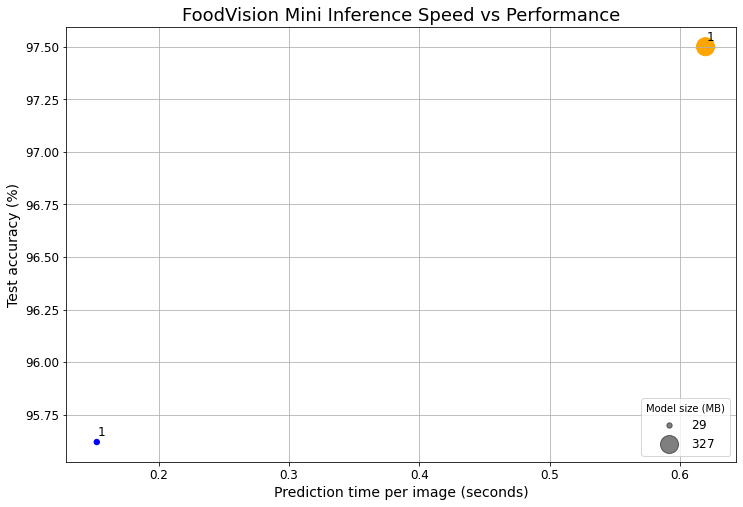

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate( s=1 , 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
# plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

In [ ]:
# Import/install Gradio
try:
  import gradio as gr
except :
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version : {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# put EffNEtB2 on CPU 
effnetb2.to("cpu")

# Check the device 
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple ,Dict
def predict(img) -> Tuple[Dict,float]:
  """ Transforms and performs a prediction on img and returns prediction and time taken """

  # Start the timer 
  start_time=timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)
  
  # put model into evaluation mode and turn on inference mode 
  effnetb2.eval()
  with torch.inference_mode():
    #pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs =torch.softmax(effnetb2(img),dim=1)
    
  # Create a prediction label and prediction probability dictionaty foe each prediction class (this is the required format for Gardio's output parameter)
  pred_labels_and_probs={class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}
  print("pred_probs [0]:", pred_probs[0][1] ,class_names[1],"\n")
  # Calculate the prediction time 
  pred_time=round(timer()-start_time,5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs ,pred_time

In [ ]:
import random 
from PIL import Image 

# Get a list of all test image filepaths
test_data_paths=list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path= random.sample(test_data_paths ,k=1)[0] # return list of elements of length k chosen from the test_data_path ,[0] -> first index of list (image path)

# Open the target image
image=Image.open(random_image_path)
print(f"[INFO] Predicting on image at path :{random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict,pred_time =predict(img=image)
print(f"Prediction label and probability dictionary : \n {pred_dict}")
print(f"Prediction time :{pred_time} seconds")

[INFO] Predicting on image at path :data/pizza_steak_sushi_20_percent/test/sushi/1844723.jpg

pred_probs [0]: tensor(0.1825) steak 

Prediction label and probability dictionary : 
 {'pizza': 0.07576518505811691, 'steak': 0.18253949284553528, 'sushi': 0.7416952848434448}
Prediction time :0.12647 seconds


In [ ]:
# Create a list of example inputs to our Garido demo 
example_list= [[str(filepath)] for filepath in random.sample(test_data_paths ,k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg']]

In [ ]:
from tables import description
import gradio as gr
# Create title, description and article strings
title="FoodVision Mini 🍕🥩🍣"
description="An EfficientNetB2 features extractor computer vision model to classify images of food as pizza, steak or sushi."
article="Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo=gr.Interface(fn=predict, # mapping function from input to output
                  inputs=gr.Image(type="pil"),# what are the inputs?
                  outputs=[gr.Label(num_top_classes=3 ,label="predictions"),# what are the outputs?
                           gr.Number(label="prediction time (s)")], # our function has 2 outputs
                  examples=example_list,
                  title=title,
                  description=description,
                  article=article)
# Launch the demo !
demo.launch(debug=False,# print errors locally ?
            share=True) # generate a publically shareable URL ?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://699f322a-c801-4aec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
# Check what's in the folder
!ls demos/foodvision_mini/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an axample directory
foodvision_mini_example_path=foodvision_mini_demo_path /"example"
foodvision_mini_example_path.mkdir(parents=True,exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples=[Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                          Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                          Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the example directory
for example in foodvision_mini_examples:
  destination= foodvision_mini_example_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example ,dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/example/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/example/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/example/2582289.jpg


In [ ]:
import os 

# Get example filepaths in a list of lists
example_list=[["example/"+ example] for example in os.listdir(foodvision_mini_example_path)]
example_list

[['example/2582289.jpg'], ['example/592799.jpg'], ['example/3622237.jpg']]

In [ ]:
import shutil
# Create a source path for our target model
effnetb2_foodvision_mini_model_path="models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination=foodvision_mini_demo_path /effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try :
    print(f"[INFO] Attemping to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
               dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")
    
# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attemping to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch 
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                       seed:int=42):
    """Creates an EfficentNetB2 feature extractor model and transforms.
    Args:
        num_classes(int,optional) : number of classes in the classifier head.defaults to 3 .
        
        seed (int ,optional) : random seed value . Defaults to 42 .
    
    Returns: 
        model (torch.nn.Module):EffNetB2 feature extractor model .
        transforms (torchvision.transforms): EffNetB2 image transforms .
    """
    
    # Create EffNetB2 pretrained weights, transforms and model
    weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms=weights.transforms()
    model= torchvision.models.efficeintnet_b2(weights=weights)
    
    # Freeze all layers in base model
    for param in model.parameters():
        param.require_grad=False
        
    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
    nn.Dropout(p=0.3 , inplace=True),
    nn.Linear(in_features=1408 , out_features=num_classes))
    
    return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [ ]:
gr.__version__

'3.17.0'

In [ ]:
%%writefile demos/foodvision_mini/requirments.txt
torch==1.13.0
torchvision==0.14.0
gradio==3.16.2

Writing demos/foodvision_mini/requirments.txt


In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
example
model.py
requirments.txt


In [ ]:
# Change into and then zip foodvisin_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x  "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")


  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: example/ (stored 0%)
  adding: example/2582289.jpg (deflated 17%)
  adding: example/592799.jpg (deflated 1%)
  adding: example/3622237.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: requirments.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/EmanAbelwhab/foodvision_mini/+", width=900, height=750)